In [8]:
import numpy as np
import json

# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# シグモイド関数の微分
def sigmoid_derivative(x):
    return x * (1 - x)

# ニューロン情報付きモデルの保存関数
def save_model_text(file_name, weights_input_hidden, weights_hidden_output, bias_hidden, bias_output):
    model_data = {
        "hidden_layer": {
            f"neuron_{i}": {
                "weights": weights_input_hidden[:, i].tolist(),
                "bias": bias_hidden[0][i]
            }
            for i in range(weights_input_hidden.shape[1])
        },
        "output_layer": {
            f"neuron_{i}": {
                "weights": weights_hidden_output[:, i].tolist(),
                "bias": bias_output[0][i]
            }
            for i in range(weights_hidden_output.shape[1])
        }
    }
    with open(file_name, "w") as f:
        json.dump(model_data, f, indent=4)
    print(f"Model with neuron details saved to {file_name}")

# モデルの読み込み関数
def load_model_text(file_name):
    with open(file_name, "r") as f:
        model_data = json.load(f)
    print(f"Model loaded from {file_name}")
    hidden_layer_weights = np.array([neuron["weights"] for neuron in model_data["hidden_layer"].values()]).T
    hidden_layer_bias = np.array([[neuron["bias"] for neuron in model_data["hidden_layer"].values()]])
    output_layer_weights = np.array([neuron["weights"] for neuron in model_data["output_layer"].values()]).T
    output_layer_bias = np.array([[neuron["bias"] for neuron in model_data["output_layer"].values()]])
    return hidden_layer_weights, output_layer_weights, hidden_layer_bias, output_layer_bias

# # ファイルからトレーニングデータを読み込む関数
def load_training_data(file_name, label, num_classes):
    data = []
    with open(file_name, "r") as f:
        # ファイル内容を空白行で区切り、それぞれを解析
        blocks = f.read().strip().split("\n\n")
        for block in blocks:
            # 各ブロックを8行5列のリストとして読み込む
            pattern = [list(map(int, line.strip("[],\n").split(","))) for line in block.split("\n")]
            # 配列を1次元化
            flattened_pattern = np.array(pattern).flatten()
            # ラベルをone-hotエンコーディング
            one_hot_label = [1 if i == label else 0 for i in range(num_classes)]
            data.append((flattened_pattern, one_hot_label))
    return data


# # ファイルからトレーニングデータを読み込む関数
# def load_training_data(file_name, label, num_classes):
#     data = []
#     with open(file_name, "r") as f:
#         # ファイル内容を空白行で区切り、それぞれを解析
#         blocks = f.read().strip().split("\n\n")
#         for block in blocks:
#             try:
#                 # 各ブロックを8行5列のリストとして読み込む
#                 pattern = [list(map(int, line.strip("[],\n ").split(","))) for line in block.split("\n") if line.strip()]
#                 if len(pattern) == 8 and all(len(row) == 5 for row in pattern):  # 行数と列数を確認
#                     # 配列を1次元化
#                     flattened_pattern = np.array(pattern).flatten()
#                     # ラベルをone-hotエンコーディング
#                     one_hot_label = [1 if i == label else 0 for i in range(num_classes)]
#                     data.append((flattened_pattern, one_hot_label))
#                 else:
#                     print(f"Skipped block due to incorrect dimensions: {block}")
#             except ValueError as e:
#                 print(f"Error processing block: {block}, Error: {e}")
#     return data


# # ファイルからトレーニングデータを読み込む関数
# def load_training_data(file_name, label, num_classes):
#     data = []
#     with open(file_name, "r") as f:
#         # ファイル内容を空白行で区切り、それぞれを解析
#         blocks = f.read().strip().split("\n\n")
#         for block in blocks:
#             try:
#                 # 各ブロックを8行5列のリストとして読み込む
#                 pattern = []
#                 for line in block.split("\n"):
#                     # 各行の処理
#                     line = line.strip("[],\n ")
#                     if not line:  # 空行をスキップ
#                         continue
#                     try:
#                         row = list(map(int, line.split(",")))  # 数値に変換
#                         if len(row) != 5:  # 列数が5以外ならエラー
#                             raise ValueError("Invalid row length")
#                         pattern.append(row)
#                     except ValueError:
#                         print(f"Skipped invalid row: {line}")
#                         break  # 不正な行があればこのブロックをスキップ
#                 if len(pattern) == 8:  # ブロックが8行5列であることを確認
#                     flattened_pattern = np.array(pattern).flatten()  # 1次元化
#                     # ラベルをone-hotエンコーディング
#                     one_hot_label = [1 if i == label else 0 for i in range(num_classes)]
#                     data.append((flattened_pattern, one_hot_label))
#                 else:
#                     print(f"Skipped invalid block: {block}")
#             except Exception as e:
#                 print(f"Error processing block: {block}, Error: {e}")
#     return data


# トレーニングデータの準備
def prepare_training_data(data_files, num_classes):
    all_data = []
    for label, file_name in enumerate(data_files):
        all_data += load_training_data(file_name, label, num_classes)
    np.random.shuffle(all_data)  # データをランダムにシャッフル
    inputs = np.array([item[0] for item in all_data])
    outputs = np.array([item[1] for item in all_data])
    return inputs, outputs

# ニューラルネットワークのトレーニング関数
def train_neural_network(training_inputs, training_outputs, input_size, hidden_size, output_size, learning_rate, epochs, model_file):
    # 重みとバイアスの初期化
    np.random.seed(42)
    weights_input_hidden = np.random.uniform(-1, 1, (input_size, hidden_size))
    weights_hidden_output = np.random.uniform(-1, 1, (hidden_size, output_size))
    bias_hidden = np.random.uniform(-1, 1, (1, hidden_size))
    bias_output = np.random.uniform(-1, 1, (1, output_size))

    # トレーニングループ
    for epoch in range(epochs):
        # フォワードパス
        hidden_layer_input = np.dot(training_inputs, weights_input_hidden) + bias_hidden
        hidden_layer_output = sigmoid(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
        predicted_output = sigmoid(output_layer_input)

        # 誤差計算
        error = training_outputs - predicted_output

        # バックプロパゲーション
        d_predicted_output = error * sigmoid_derivative(predicted_output)
        error_hidden_layer = d_predicted_output.dot(weights_hidden_output.T)
        d_hidden_layer = error_hidden_layer * sigmoid_derivative(hidden_layer_output)

        # 重みとバイアスの更新
        weights_hidden_output += hidden_layer_output.T.dot(d_predicted_output) * learning_rate
        weights_input_hidden += training_inputs.T.dot(d_hidden_layer) * learning_rate
        bias_output += np.sum(d_predicted_output, axis=0, keepdims=True) * learning_rate
        bias_hidden += np.sum(d_hidden_layer, axis=0, keepdims=True) * learning_rate

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Error: {np.mean(np.abs(error))}")

    # モデルを保存
    save_model_text(model_file, weights_input_hidden, weights_hidden_output, bias_hidden, bias_output)

# ファイル名
data_files = [f"data_{i}.txt" for i in range(3)]  # 例: 3クラス (0, 1, 2) のファイル
model_file = "trained_model.json"

# ニューラルネットワークの設定
input_size = 8 * 5  # 8行5列の配列を1次元化
hidden_size = 8
output_size = len(data_files)  # クラス数に応じて変更
learning_rate = 0.1
epochs = 10000

# トレーニングデータの準備
training_inputs, training_outputs = prepare_training_data(data_files, output_size)

# トレーニングの実行
train_neural_network(training_inputs, training_outputs, input_size, hidden_size, output_size, learning_rate, epochs, model_file)


Epoch 0, Error: 0.45092312386040173
Epoch 1000, Error: 0.039977422344340846
Epoch 2000, Error: 0.026346319801524146
Epoch 3000, Error: 0.020886151719366138
Epoch 4000, Error: 0.017778788034871915
Epoch 5000, Error: 0.015717413987506156
Epoch 6000, Error: 0.01422533455615493
Epoch 7000, Error: 0.01308254588950734
Epoch 8000, Error: 0.012171877745227577
Epoch 9000, Error: 0.01142454507688926
Model with neuron details saved to trained_model.json


Model loaded from trained_model_r.json


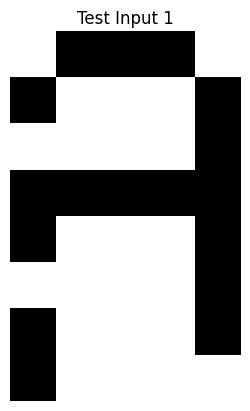

Test Input 1: Predicted Output (Raw): [[0.93552226 0.0912728  0.00320074]]
Test Input 1: Predicted Class: 0 with confidence 0.94


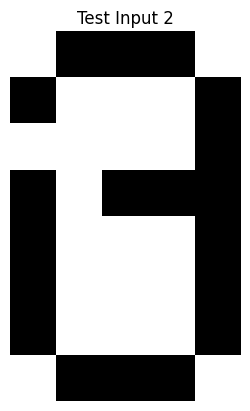

Test Input 2: Predicted Output (Raw): [[0.00713141 0.42754469 0.25080216]]
Test Input 2: Predicted Class: 1 with confidence 0.43


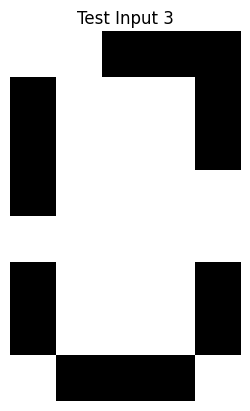

Test Input 3: Predicted Output (Raw): [[0.01157818 0.00511548 0.97925181]]
Test Input 3: Predicted Class: 2 with confidence 0.98


In [10]:
import numpy as np
import json
import matplotlib.pyplot as plt

# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# モデルの読み込み関数
def load_model_text(file_name):
    with open(file_name, "r") as f:
        model_data = json.load(f)
    print(f"Model loaded from {file_name}")
    hidden_layer_weights = np.array([neuron["weights"] for neuron in model_data["hidden_layer"].values()]).T
    hidden_layer_bias = np.array([[neuron["bias"] for neuron in model_data["hidden_layer"].values()]])
    output_layer_weights = np.array([neuron["weights"] for neuron in model_data["output_layer"].values()]).T
    output_layer_bias = np.array([[neuron["bias"] for neuron in model_data["output_layer"].values()]])
    return hidden_layer_weights, output_layer_weights, hidden_layer_bias, output_layer_bias

# ファイルから8行5列のビットデータを読み込む関数
def load_test_data(file_name):
    test_data = []
    with open(file_name, "r") as f:
        blocks = f.read().strip().split("\n\n")  # 空白行で区切る
        for block in blocks:
            try:
                # 各ブロックを8行5列のリストとして読み込む
                pattern = [list(map(int, line.strip("[],\n ").split(","))) for line in block.split("\n") if line.strip()]
                if len(pattern) == 8 and all(len(row) == 5 for row in pattern):
                    flattened_pattern = np.array(pattern).flatten()  # 1次元化
                    test_data.append(flattened_pattern)
                else:
                    print(f"Skipped invalid block: {block}")
            except ValueError as e:
                print(f"Error processing block: {block}, Error: {e}")
    return test_data

# パターン表示関数
def display_pattern(pattern, title=""):
    pattern_reshaped = np.array(pattern).reshape(8, 5)  # 8行5列に変換
    plt.imshow(pattern_reshaped, cmap="Greys", interpolation="nearest")
    plt.title(title)
    plt.axis("off")
    plt.show()

# モデルを読み込む
# weights_input_hidden, weights_hidden_output, bias_hidden, bias_output = load_model_text("trained_model.json")
weights_input_hidden, weights_hidden_output, bias_hidden, bias_output = load_model_text("trained_model_r.json")

# テストデータを読み込む
test_data = load_test_data("data_check.txt")  # テストファイルを指定
if not test_data:
    print("No valid test data found.")
else:
    for idx, test_input in enumerate(test_data):
        # フォワードパス
        test_input = np.array(test_input).reshape(1, -1)  # 1次元配列を2次元配列に変換
        hidden_layer_input = np.dot(test_input, weights_input_hidden) + bias_hidden
        hidden_layer_output = sigmoid(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
        predicted_output = sigmoid(output_layer_input)

        # 推論結果を表示
        display_pattern(test_input.flatten(), title=f"Test Input {idx + 1}")
        print(f"Test Input {idx + 1}: Predicted Output (Raw):", predicted_output)

        # 最も確率の高いクラスを判定
        predicted_class = np.argmax(predicted_output)
        confidence = predicted_output[0][predicted_class]  # 最も高い確率
        print(f"Test Input {idx + 1}: Predicted Class: {predicted_class} with confidence {confidence:.2f}")

追加学習のファイルを_r付きで固定するコード

In [7]:
import numpy as np
import json
import os

# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# シグモイド関数の微分
def sigmoid_derivative(x):
    return x * (1 - x)

# ニューロン情報付きモデルの保存関数
def save_model_text(file_name, weights_input_hidden, weights_hidden_output, bias_hidden, bias_output):
    model_data = {
        "hidden_layer": {
            f"neuron_{i}": {
                "weights": weights_input_hidden[:, i].tolist(),
                "bias": bias_hidden[0][i]
            }
            for i in range(weights_input_hidden.shape[1])
        },
        "output_layer": {
            f"neuron_{i}": {
                "weights": weights_hidden_output[:, i].tolist(),
                "bias": bias_output[0][i]
            }
            for i in range(weights_hidden_output.shape[1])
        }
    }
    with open(file_name, "w") as f:
        json.dump(model_data, f, indent=4)
    print(f"Model saved to {file_name}")

# モデルの読み込み関数
def load_model_text(file_name):
    with open(file_name, "r") as f:
        model_data = json.load(f)
    print(f"Model loaded from {file_name}")
    hidden_layer_weights = np.array([neuron["weights"] for neuron in model_data["hidden_layer"].values()]).T
    hidden_layer_bias = np.array([[neuron["bias"] for neuron in model_data["hidden_layer"].values()]])
    output_layer_weights = np.array([neuron["weights"] for neuron in model_data["output_layer"].values()]).T
    output_layer_bias = np.array([[neuron["bias"] for neuron in model_data["output_layer"].values()]])
    return hidden_layer_weights, output_layer_weights, hidden_layer_bias, output_layer_bias

# ファイルからトレーニングデータを読み込む関数
def load_training_data(file_name, label, num_classes):
    data = []
    if not os.path.exists(file_name) or os.path.getsize(file_name) == 0:  # ファイルが空または存在しない場合
        return data  # 空リストを返す
    with open(file_name, "r") as f:
        blocks = f.read().strip().split("\n\n")
        for block in blocks:
            pattern = [list(map(int, line.strip("[],\n").split(","))) for line in block.split("\n")]
            flattened_pattern = np.array(pattern).flatten()
            one_hot_label = [1 if i == label else 0 for i in range(num_classes)]
            data.append((flattened_pattern, one_hot_label))
    return data

# トレーニングデータの準備
def prepare_training_data(data_files, num_classes):
    all_data = []
    for label, file_name in enumerate(data_files):
        all_data += load_training_data(file_name, label, num_classes)
    np.random.shuffle(all_data)
    inputs = np.array([item[0] for item in all_data])
    outputs = np.array([item[1] for item in all_data])
    return inputs, outputs

# ニューラルネットワークのトレーニング関数
# def train_neural_network(training_inputs, training_outputs, weights_input_hidden, weights_hidden_output, bias_hidden, bias_output, learning_rate, epochs, model_file):
#     for epoch in range(epochs):
#         # フォワードパス
#         hidden_layer_input = np.dot(training_inputs, weights_input_hidden) + bias_hidden
#         hidden_layer_output = sigmoid(hidden_layer_input)
#         output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
#         predicted_output = sigmoid(output_layer_input)

#         # 誤差計算
#         error = training_outputs - predicted_output

#         # バックプロパゲーション
#         d_predicted_output = error * sigmoid_derivative(predicted_output)
#         error_hidden_layer = d_predicted_output.dot(weights_hidden_output.T)
#         d_hidden_layer = error_hidden_layer * sigmoid_derivative(hidden_layer_output)

#         # 重みとバイアスの更新
#         weights_hidden_output += hidden_layer_output.T.dot(d_predicted_output) * learning_rate
#         weights_input_hidden += training_inputs.T.dot(d_hidden_layer) * learning_rate
#         bias_output += np.sum(d_predicted_output, axis=0, keepdims=True) * learning_rate
#         bias_hidden += np.sum(d_hidden_layer, axis=0, keepdims=True) * learning_rate

#         if epoch % 1000 == 0:
#             print(f"Epoch {epoch}, Error: {np.mean(np.abs(error))}")

#     # 出力ファイル名を更新し保存
#     output_model_file = model_file.replace(".json", "_r.json")
#     save_model_text(output_model_file, weights_input_hidden, weights_hidden_output, bias_hidden, bias_output)

def train_neural_network(training_inputs, training_outputs, weights_input_hidden, weights_hidden_output, bias_hidden, bias_output, learning_rate, epochs, model_file):
    if training_inputs.size == 0 or training_outputs.size == 0:  # データが空の場合
        print("No training data provided. Skipping training.")
        return  # 学習をスキップ

    for epoch in range(epochs):
        # フォワードパス
        hidden_layer_input = np.dot(training_inputs, weights_input_hidden) + bias_hidden
        hidden_layer_output = sigmoid(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
        predicted_output = sigmoid(output_layer_input)

        # 誤差計算
        error = training_outputs - predicted_output

        # バックプロパゲーション
        d_predicted_output = error * sigmoid_derivative(predicted_output)
        error_hidden_layer = d_predicted_output.dot(weights_hidden_output.T)
        d_hidden_layer = error_hidden_layer * sigmoid_derivative(hidden_layer_output)

        # 重みとバイアスの更新
        weights_hidden_output += hidden_layer_output.T.dot(d_predicted_output) * learning_rate
        weights_input_hidden += training_inputs.T.dot(d_hidden_layer) * learning_rate
        bias_output += np.sum(d_predicted_output, axis=0, keepdims=True) * learning_rate
        bias_hidden += np.sum(d_hidden_layer, axis=0, keepdims=True) * learning_rate

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Error: {np.mean(np.abs(error))}")

    # 出力ファイル名を更新し保存
    output_model_file = model_file.replace(".json", "_r.json")
    save_model_text(output_model_file, weights_input_hidden, weights_hidden_output, bias_hidden, bias_output)


# 元データファイルと追加データファイルの準備
additional_files = [f"data_{i}_r1.txt" for i in range(3)]  # 追加データファイル

# モデルファイル
model_file = "trained_model.json"

# モデルを読み込む
weights_input_hidden, weights_hidden_output, bias_hidden, bias_output = load_model_text(model_file)

# トレーニングデータの準備（追加データのみ）
training_inputs, training_outputs = prepare_training_data(additional_files, len(additional_files))

# 追加学習の実行
learning_rate = 0.1
epochs = 10000
train_neural_network(training_inputs, training_outputs, weights_input_hidden, weights_hidden_output, bias_hidden, bias_output, learning_rate, epochs, model_file)

Model loaded from trained_model.json
Epoch 0, Error: 0.01532786234026532
Epoch 1000, Error: 0.012537273834961338
Epoch 2000, Error: 0.01155269067537093
Epoch 3000, Error: 0.010896334901884639
Epoch 4000, Error: 0.010381747881709518
Epoch 5000, Error: 0.009950461872350902
Epoch 6000, Error: 0.009576471916803306
Epoch 7000, Error: 0.009245509318355464
Epoch 8000, Error: 0.008948603282409812
Epoch 9000, Error: 0.008679579382340884
Model saved to trained_model_r.json
